In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

# Imports

In [3]:
import configparser

import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import modulephaselib

# Dataset

In [4]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [5]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# I/Q samples to Module/Phase conversion

Each signal is transformed from an I/Q sample to his Module/Phase representation, and added as a column to the dataset.

In [6]:
dataset_df = modulephaselib.transform_and_add_signals_to_dataframe(dataset_df)

## The dataset after adding Module/Phase signals

In [7]:
dataset_df

,IQ signals,Modulation_Label,SNR,MP signals
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2,"([0.009777415810077348, 0.008160794610184235, ..."
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2,"([0.006428271419970337, 0.0018729896699540463,..."
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2,"([0.006714471814517775, 0.010443807990507132, ..."
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2,"([0.0036471206082490607, 0.008847963411403753,..."
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2,"([0.01363757358555227, 0.004953662955395487, 0..."
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18,"([0.007888647836121875, 0.00518580783630137, 0..."
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18,"([0.004378196387910148, 0.006676949935829746, ..."
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18,"([0.013097595344676685, 0.008587072893700217, ..."
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18,"([0.004868425922433083, 0.01011580181134021, 0..."


# Neural network

## Configuration

In [8]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', 'FreeHandV2')
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [9]:
signals = modulephaselib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [10]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [11]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [12]:
model = neural_networks.freehand_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
dense (Dense)                (None, 2, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 128, 32)        32800     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 64, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0     

### Train the model

In [13]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100
162/162 [==============================] - 31s 88ms/step - loss: 2.1360 - val_loss: 1.8896
Epoch 2/100
162/162 [==============================] - 13s 82ms/step - loss: 1.7889 - val_loss: 1.6083
Epoch 3/100
162/162 [==============================] - 13s 81ms/step - loss: 1.5604 - val_loss: 1.5190
Epoch 4/100
162/162 [==============================] - 12s 72ms/step - loss: 1.4748 - val_loss: 1.4825
Epoch 5/100
162/162 [==============================] - 13s 82ms/step - loss: 1.4167 - val_loss: 1.4615
Epoch 6/100
162/162 [==============================] - 14s 86ms/step - loss: 1.3673 - val_loss: 1.4307
Epoch 7/100
162/162 [==============================] - 14s 87ms/step - loss: 1.3115 - val_loss: 1.4162
Epoch 8/100
162/162 [==============================] - 13s 79ms/step - loss: 1.2586 - val_loss: 1.4127
Epoch 9/100
162/162 [==============================] - 13s 79ms/step - loss: 1.2094 - val_loss: 1.4195
Epoch 10/100
162/162 [==============================] - 13s 82ms/step - l

# Evaluate and Plot Model Performance

In [14]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

54/54 [==============================] - 1s 26ms/step - loss: 1.4127
1.4127117395401


## Loss

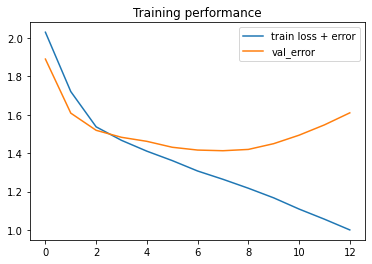

In [15]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

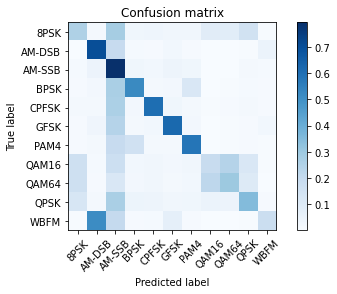

In [16]:
evaluationlib.plot_confusion_matrix(model, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08135215453194651
Overall Accuracy:  0.09722735674676525
Overall Accuracy:  0.0975609756097561
Overall Accuracy:  0.12122276879831342
Overall Accuracy:  0.14920520231213874
Overall Accuracy:  0.19799498746867167
Overall Accuracy:  0.2898602651379434
Overall Accuracy:  0.389171511627907
Overall Accuracy:  0.4504792332268371
Overall Accuracy:  0.5470884255930984
Overall Accuracy:  0.6368917937545389
Overall Accuracy:  0.6685899747565813
Overall Accuracy:  0.6834914611005692
Overall Accuracy:  0.6880597014925374
Overall Accuracy:  0.7053314121037464
Overall Accuracy:  0.7094422165512213
Overall Accuracy:  0.7038134024435394
Overall Accuracy:  0.6912373072583679
Overall Accuracy:  0.6875460574797347
Overall Accuracy:  0.710752688172043


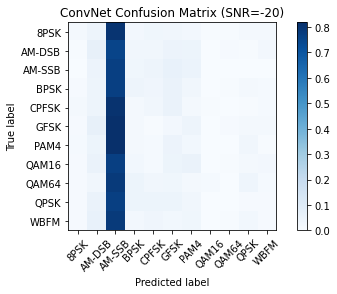

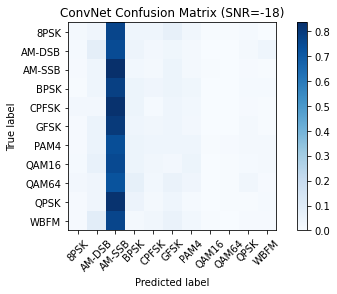

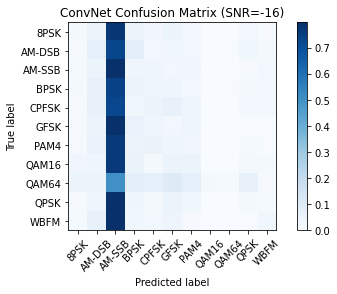

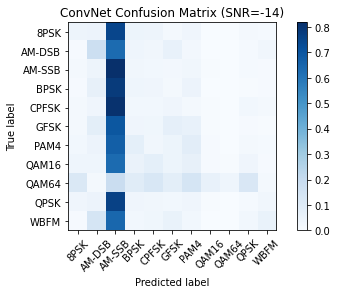

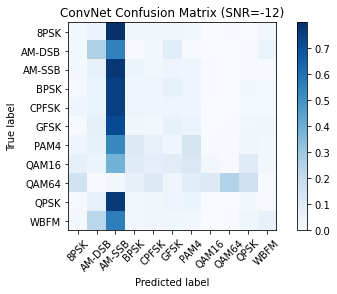

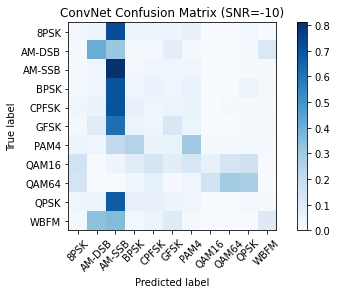

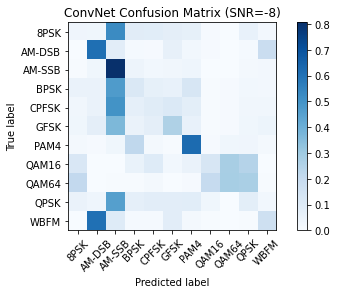

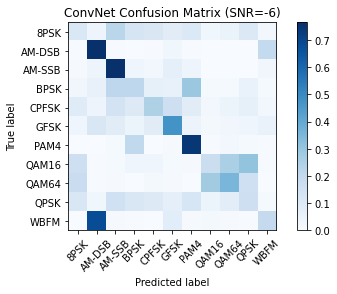

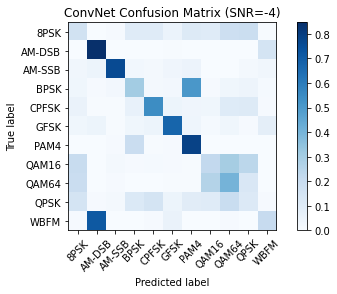

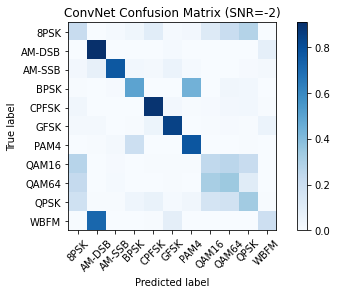

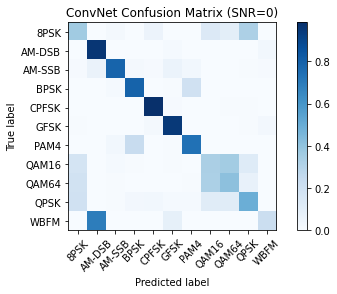

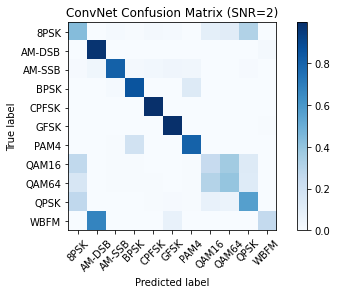

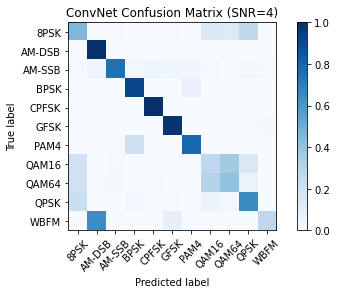

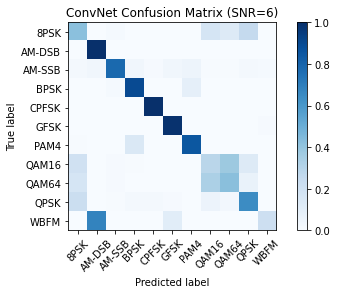

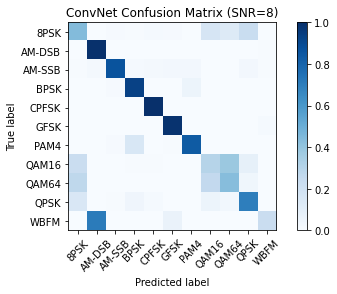

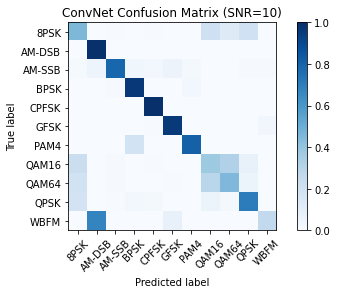

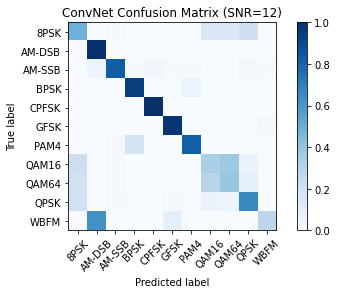

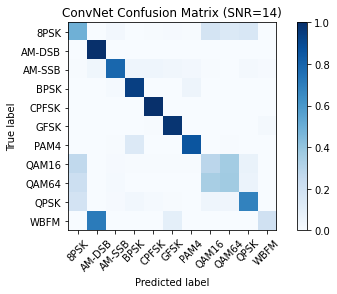

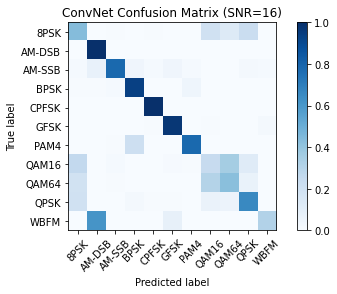

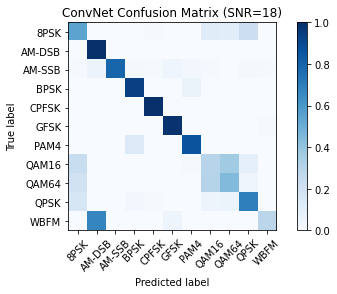

In [17]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [18]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,12,14,19,28,38,45,54,63,66,68,68,70,70,70,69,68,71


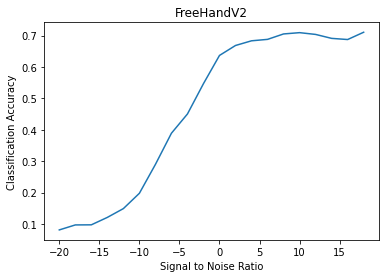

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)